In this code note, I will present some time series techniques applied on activities sequences of human/bot users to predict number of activities to efficiently use Github api.

# Packages importing & visualisation

In [1]:
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA

In [6]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", UserWarning)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
pd.set_option('display.max_columns', None)

In [13]:
activities = pd.read_parquet('../data-raw/activities.parquet')

In [19]:
activities_by_day = (
    activities[activities['category']=='human']
    .assign(date=pd.to_datetime(activities['date']).dt.date)
    # Grouping data by contributor and date, and counting up the activities by day
    .groupby(['contributor', 'date'])
    .activity
    .count()
    .reset_index(name='n_activities')
)
activities_by_day.head()

,contributor,date,n_activities
0,333363,2022-11-29,1
1,333363,2022-11-30,4
2,333363,2022-12-02,1
3,333363,2022-12-11,2
4,333363,2022-12-14,1


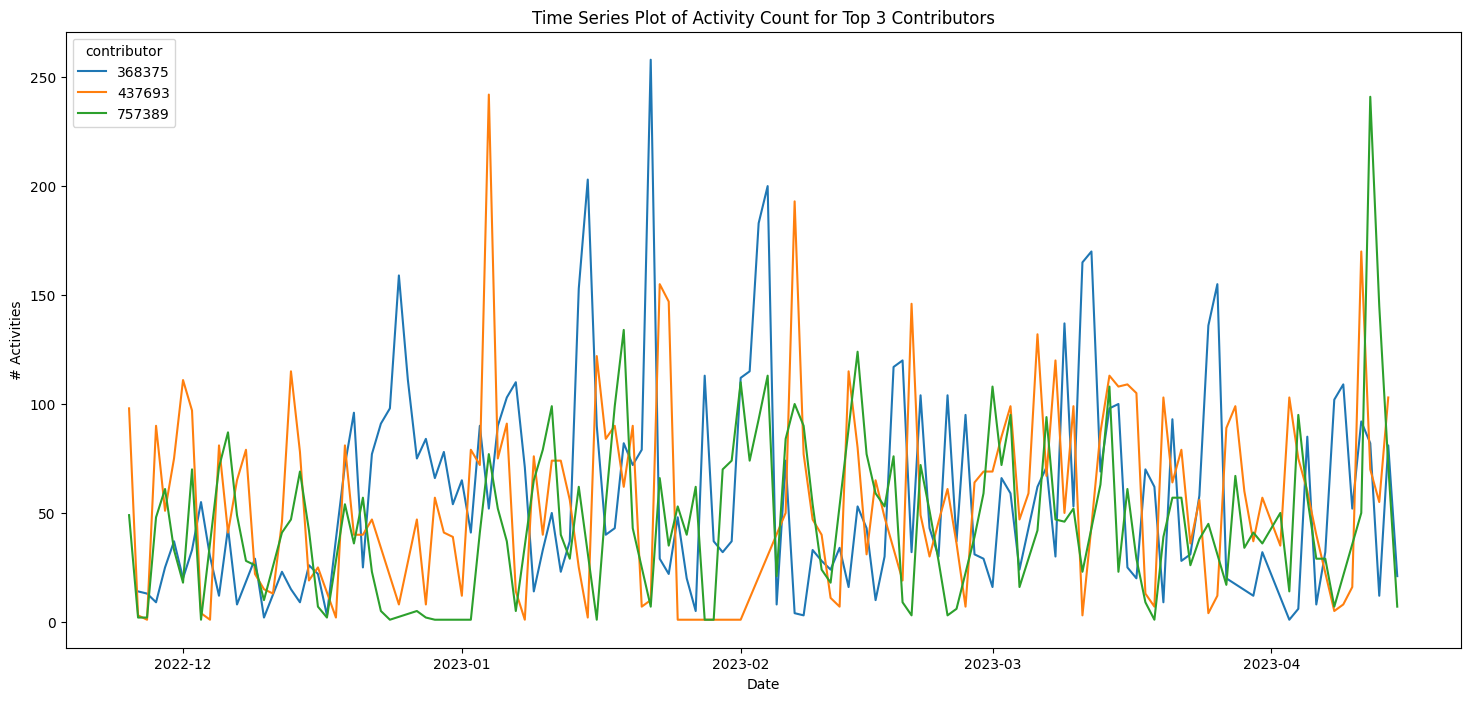

In [20]:
temp = (
    activities_by_day[
        activities_by_day['contributor']
        .isin(activities_by_day
              .groupby('contributor')['n_activities']
              .median()
              .nlargest(3)
              .index
            )
    ]
)

# Plotting the time series
plt.figure(figsize=(18, 8))
sns.lineplot(x='date', y='n_activities', hue='contributor', data=temp)
plt.title('Time Series Plot of Activity Count for Top 3 Contributors')
plt.xlabel('Date')
plt.ylabel('# Activities')
plt.show()


In [22]:
activities_by_time = (
    activities
    .assign(datetime=activities['date'].dt.strftime('%Y-%m-%d %H:00:00'))
    .groupby(['contributor', 'datetime'])
    .activity.count()
    .unstack(fill_value=0).stack()
    .reset_index(name='n_activities')
)
activities_by_time.head()

,contributor,datetime,n_activities
0,0crat,2022-11-25 09:00:00,0
1,0crat,2022-11-25 10:00:00,0
2,0crat,2022-11-25 11:00:00,1
3,0crat,2022-11-25 12:00:00,1
4,0crat,2022-11-25 13:00:00,6


# Multiple linear regression model

In [19]:
# Get the data of the top contributor 'codeclimate[bot]' to test time series forcasting method
temp = (
    activities_by_day[activities_by_day['contributor'] == 'codeclimate[bot]']
    .drop(['contributor'], axis=1)
    .reset_index(drop=True)
)

# Feature Engineering: create lag features based on the n previous dates
n_previous_dates = 13
for i in range(1, n_previous_dates+1):
    temp[f'n_activities_lag_{i}'] = temp['n_activities'].shift(i)

# Delete the n first rows to avoid NaN values
temp = temp.iloc[n_previous_dates:].reset_index(drop=True)

In [20]:
temp

,date,n_activities,n_activities_lag_1,n_activities_lag_2,n_activities_lag_3,n_activities_lag_4,n_activities_lag_5,n_activities_lag_6,n_activities_lag_7,n_activities_lag_8,n_activities_lag_9,n_activities_lag_10,n_activities_lag_11,n_activities_lag_12,n_activities_lag_13
0,2022-12-08,539,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0,142.0
1,2022-12-09,361,539.0,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0,191.0
2,2022-12-10,258,361.0,539.0,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0,111.0
3,2022-12-11,211,258.0,361.0,539.0,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0,313.0
4,2022-12-12,447,211.0,258.0,361.0,539.0,452.0,359.0,314.0,183.0,173.0,219.0,404.0,321.0,450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2023-04-11,317,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0,481.0,417.0,500.0
125,2023-04-12,429,317.0,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0,481.0,417.0
126,2023-04-13,524,429.0,317.0,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0,481.0
127,2023-04-14,296,524.0,429.0,317.0,477.0,120.0,149.0,233.0,354.0,369.0,520.0,603.0,232.0,204.0


In [9]:
# Split the data into training and test sets (last 20% of the data)
train_size = int(len(temp) * 0.8)
train_data, test_data = temp[:train_size], temp[train_size:]

# Separate features and target variable for training
X_train = train_data.drop(['date', 'n_activities'], axis=1)
y_train = train_data['n_activities']

# Separate features and target variable for testing
X_test = test_data.drop(['date', 'n_activities'], axis=1)
y_test = test_data['n_activities']

# Train the time series forecasting model with multiple linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

In [10]:
# Calculate Mean Squared Error
print(f'R2 Score: {r2_score(y_test, predictions)}')
print(f'Explained variance score: {explained_variance_score(y_test, predictions)}')

R2 Score: 0.655215420552469
Explained variance score: 0.6552736527765557


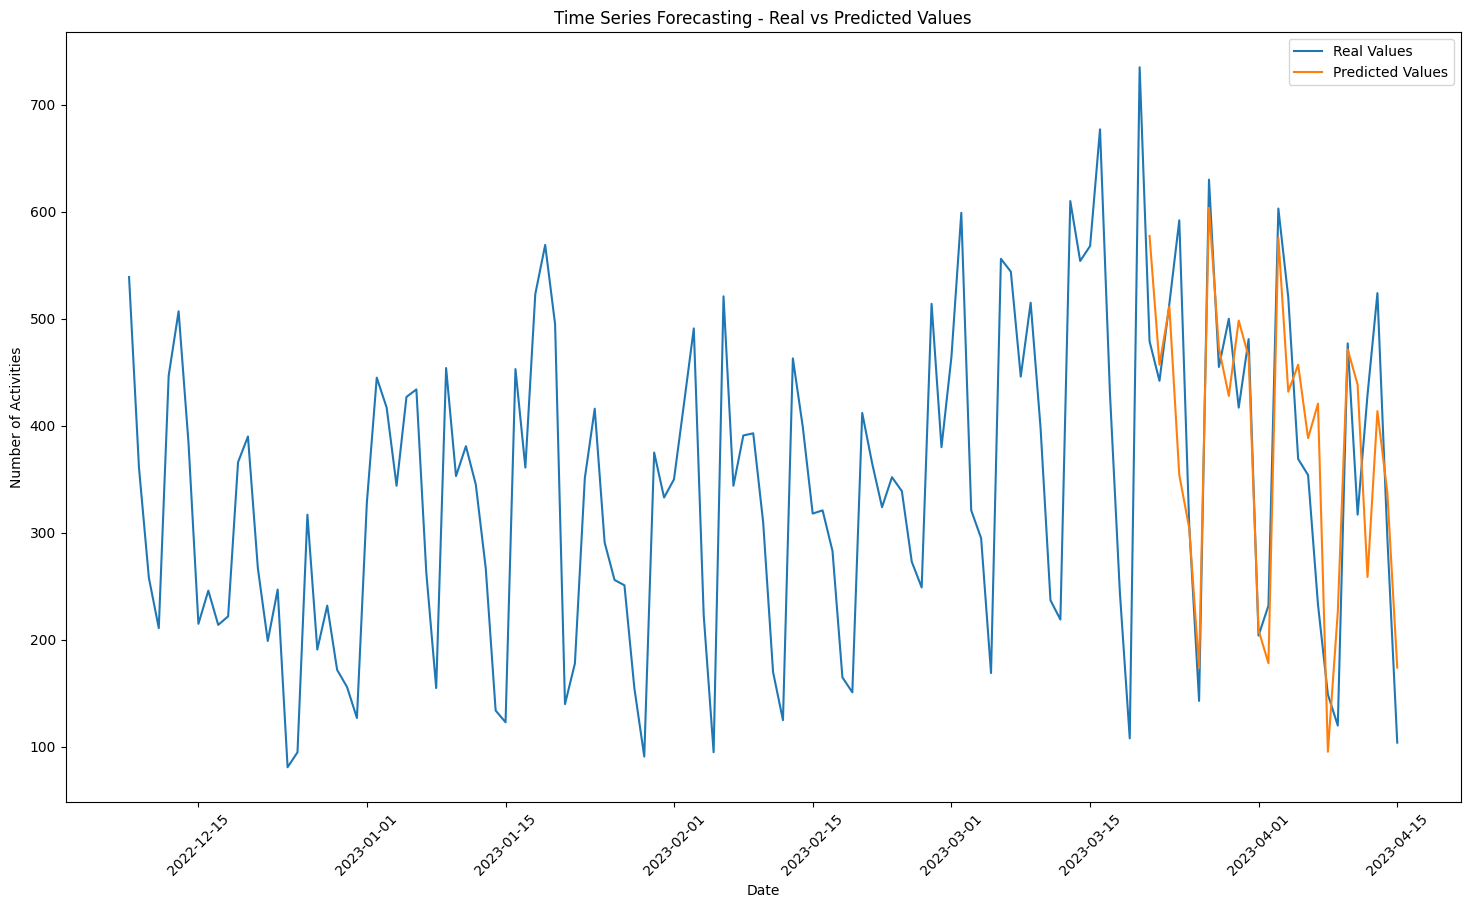

In [11]:
# Visualize Results
plt.figure(figsize=(18, 10))
sns.lineplot(x=temp['date'], y=temp['n_activities'], label='Real Values')
sns.lineplot(x=test_data['date'], y=predictions, label='Predicted Values')
plt.title('Time Series Forecasting - Real vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Multiple Seasonal-Trend decomposition using LOESS (MSTL)

In [23]:
# Get the data of the top contributor 'codeclimate[bot]' to test time series decomposition method
temp = (
    activities_by_time[activities_by_time['contributor'] == '437693']
    .drop(['contributor'], axis=1)
    .reset_index(drop=True)
    .set_index('datetime', drop=True)
)
temp.index.name = None
temp.head()

,n_activities
2022-11-25 09:00:00,0
2022-11-25 10:00:00,5
2022-11-25 11:00:00,13
2022-11-25 12:00:00,3
2022-11-25 13:00:00,8


In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

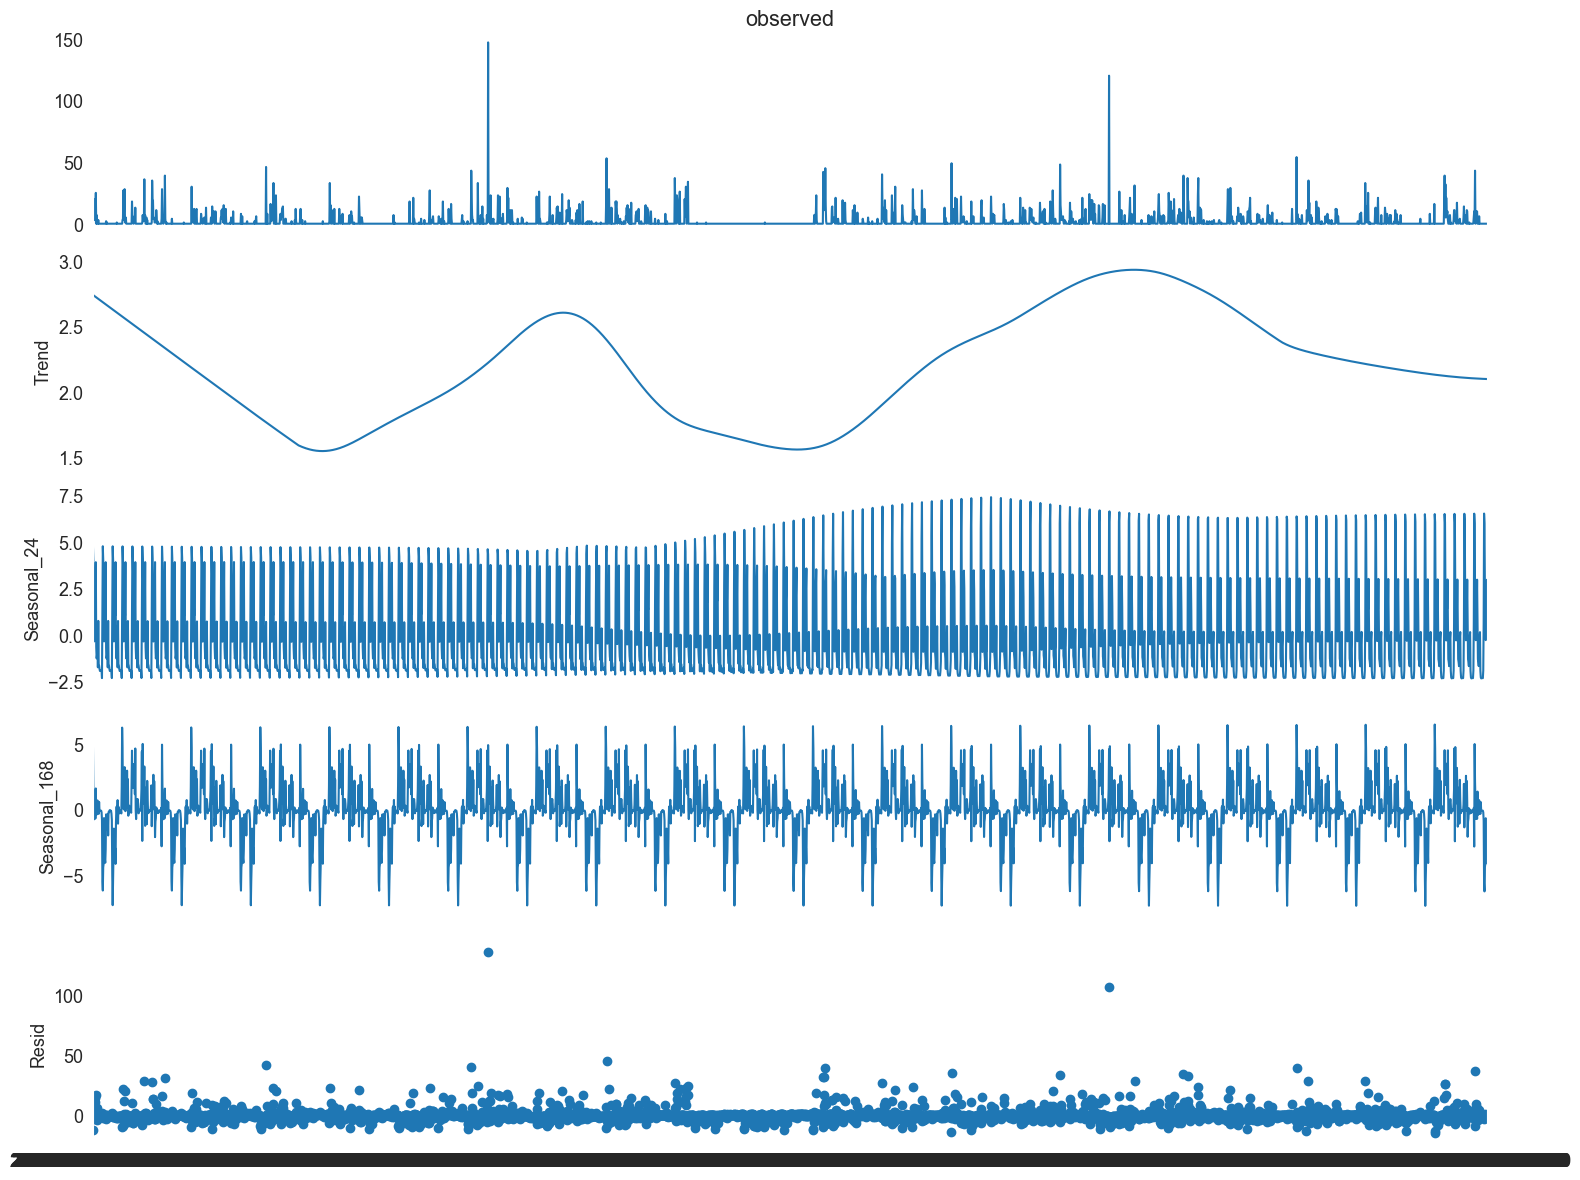

In [25]:
mstl = MSTL(
    temp,
    periods=[24, 24 * 7],
    windows=[101, 101],
    iterate=3,
    stl_kwargs={
                "trend":1001,
                "seasonal_deg":0,
               }
)
res = mstl.fit()
ax = res.plot()
plt.tight_layout()


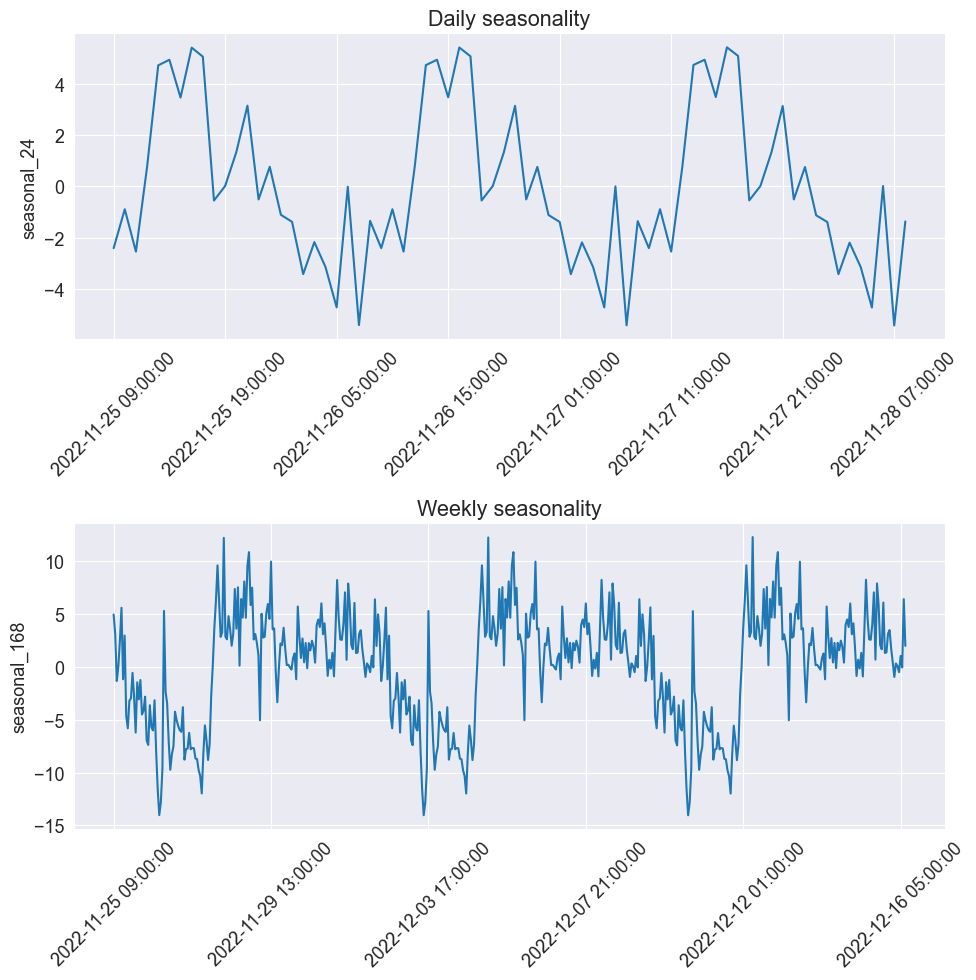

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=[10,10])
res.seasonal["seasonal_24"].iloc[:24*3].plot(ax=ax[0])
ax[0].set_ylabel("seasonal_24")
ax[0].set_title("Daily seasonality")
ax[0].tick_params(axis='x', rotation=45)

res.seasonal["seasonal_168"].iloc[:24*7*3].plot(ax=ax[1])
ax[1].set_ylabel("seasonal_168")
ax[1].set_title("Weekly seasonality")
ax[1].tick_params(axis='x', rotation=45)


plt.tight_layout()

# Autoregressive integrated moving average (Daily)

In [35]:
# Get the data of the top contributor 'sourcegraph-bot' to test time series decomposition method
temp = (
    activities_by_day[activities_by_day['contributor'] == 'pxw-bot']
    .drop(['contributor'], axis=1)
    .reset_index(drop=True)
    .set_index('date', drop=True)
    .asfreq('D')
    .fillna(0)
)
temp.index.name = None
temp

,n_activities
2022-11-25,2
2022-11-26,2
2022-11-27,2
2022-11-28,2
2022-11-29,2
...,...
2023-04-11,2
2023-04-12,2
2023-04-13,2
2023-04-14,2


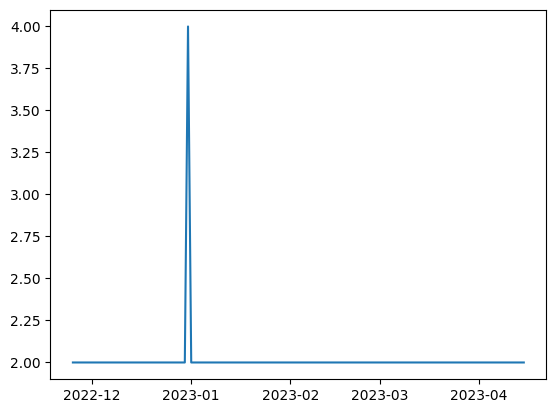

In [36]:
# Visualize the results using Seaborn
plt.plot(temp, label='Actual Data')
plt.show()

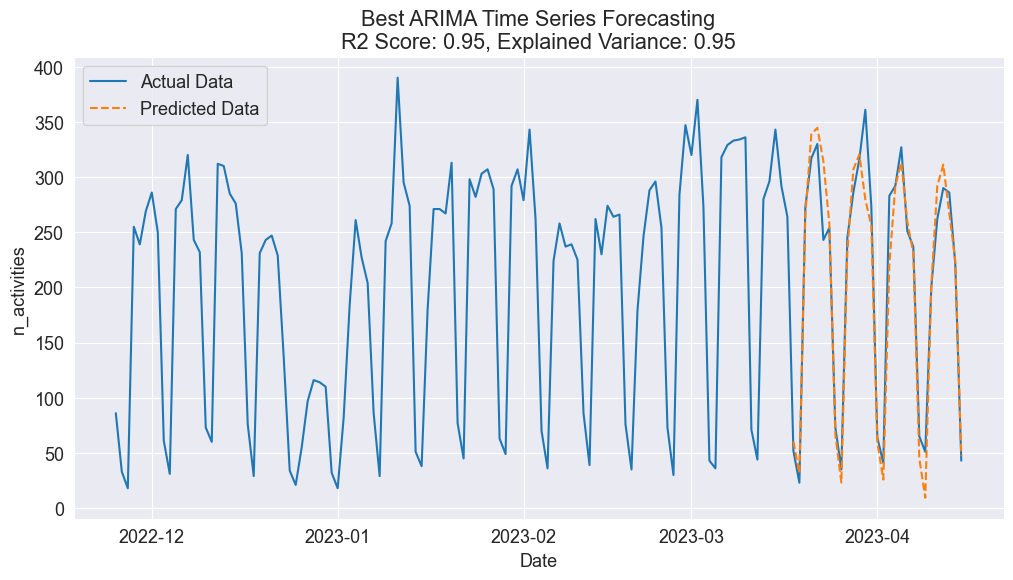

Best Model Parameters (p, d, q): (24, 2, 4)
Best R2 Score: 0.9503707026314693
Best Explained Variance Score: 0.9533639935896441


In [18]:
# Split the data into training and test sets (last 20% as test)
train_size = int(len(temp) * 0.8)
train, test = temp.iloc[:train_size], temp.iloc[train_size:]

best_r2 = -np.inf
best_explained_variance = -np.inf
best_order = None

# Define a range of values for p, d, and q
p_values = range(30)  # Adjust as needed
d_values = range(5)  # Adjust as needed
q_values = range(5)  # Adjust as needed

# Grid search for the best model parameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            model = ARIMA(train, order=order)
            model.initialize_approximate_diffuse() # this line
            fit_model = model.fit()
            predictions = fit_model.forecast(steps=len(test))
            
            r2 = r2_score(test, predictions)
            explained_variance = explained_variance_score(test, predictions)
            
            if r2 > best_r2 and explained_variance > best_explained_variance:
                best_r2 = r2
                best_explained_variance = explained_variance
                best_order = order

# Train the best model
best_model = ARIMA(train, order=best_order)
best_fit_model = best_model.fit()

# Make predictions on the entire dataset for visualization
predictions = best_fit_model.forecast(steps=len(test))

# Visualize the results using Seaborn
plt.figure(figsize=(12, 6))
plt.plot(temp, label='Actual Data')
plt.plot(predictions, label='Predicted Data', linestyle='dashed')

plt.title('Best ARIMA Time Series Forecasting\nR2 Score: {:.2f}, Explained Variance: {:.2f}'.format(best_r2, best_explained_variance))
plt.xlabel('Date')
plt.ylabel('n_activities')
plt.legend()
plt.show()

# Print the best model parameters and scores
print('Best Model Parameters (p, d, q):', best_order)
print('Best R2 Score:', best_r2)
print('Best Explained Variance Score:', best_explained_variance)

# Autoregressive integrated moving average (Hourly)

In [16]:
# Get the data of the top contributor 'sourcegraph-bot' to test time series decomposition method
temp = (
    activities_by_time[activities_by_time['contributor'] == 'codeclimate[bot]']
    .drop(['contributor'], axis=1)
    .reset_index(drop=True)
    .set_index('datetime', drop=True)
)
temp.index.name = None
temp

,n_activities
2022-11-25 09:00:00,1
2022-11-25 10:00:00,13
2022-11-25 11:00:00,9
2022-11-25 12:00:00,8
2022-11-25 13:00:00,6
...,...
2023-04-15 12:00:00,8
2023-04-15 13:00:00,8
2023-04-15 14:00:00,13
2023-04-15 15:00:00,4
